In [3]:
"""
Network Structure
-----------------

First, let's import the necessary libraries into python.

"""
from __future__ import division

import argparse, time, logging, random, math

import numpy as np
import mxnet as mx

from mxnet import gluon, nd, init
from mxnet import autograd as ag
from mxnet.gluon import nn
from mxnet.gluon.data.vision import transforms

from gluoncv.model_zoo import get_model
from gluoncv.utils import makedirs, TrainingHistory

################################################################
#
# There are numerous structures for convolutional neural networks.
# Here we pick a simple yet well-performing structure, ``cifar_resnet20_v1``, for the
# tutorial.

# number of GPUs or CPU to use if you have
num_gpus = 1
ctx = [mx.gpu(i) for i in range(num_gpus)]

# ctx = mx.cpu(0)


/home/guangyi/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [4]:
############################################################
# your code here to define your net according to problem 2 #
net = nn.Sequential()
net.add(
    nn.Conv2D(6,kernel_size=5,strides=1,activation='relu'),
    nn.MaxPool2D(pool_size=2,strides=2), #pool_size???
    nn.Conv2D(16,kernel_size=5,strides=1,activation='relu'),
    nn.MaxPool2D(pool_size=2,strides=2), #pool_size???
    nn.Dense(128,activation='relu'), #nn.Dropout(0.5)
    nn.Dense(84,activation='relu'), #nn.Dropout(0.5)
    nn.Dense(10))


############################################################
# your code here to do initialization using existing API #
net.initialize(init=init.MSRAPrelu(),ctx=ctx)
# net.initialize(init=init.Normal(0.1),ctx=ctx)


In [5]:
################################################################
# Data Augmentation and Data Loader
# ---------------------------------
#
# Data augmentation is a common technique used for training. It is
# base on the assumption that, for the same object, photos under different
# composition, lighting condition, or color should all yield the same prediction.
#
# Here are photos of the Golden Bridge, taken by many people,
# at different time from different angles.
# We can easily tell that they are photos of the same thing.
#
# |image-golden-bridge|
#
# We want to teach this invariance to our model, by playing "augmenting"
# input image. Our augmentation transforms the image with
# resizing, cropping, flipping and other techniques.
#
# With ``Gluon``, we can create our transform function as following:

transform_train = transforms.Compose([
    # Randomly crop an area, and then resize it to be 32x32
    transforms.RandomResizedCrop(32),
    # Randomly flip the image horizontally
    transforms.RandomFlipLeftRight(),
    # Randomly jitter the brightness, contrast and saturation of the image
    transforms.RandomColorJitter(brightness=0.1, contrast=0.1, saturation=0.1),
    # Randomly adding noise to the image
    transforms.RandomLighting(0.1),
    # Transpose the image from height*width*num_channels to num_channels*height*width
    # and map values from [0, 255] to [0,1]
    transforms.ToTensor(),
    # Normalize the image with mean and standard deviation calculated across all images
    transforms.Normalize([0.4914, 0.4822, 0.4465], [0.2023, 0.1994, 0.2010])
])

################################################################
# You may have noticed that most of the operations are randomized. This in effect
# increases the number of different images the model sees during training.
# The more data we have, the better our model generalizes over
# unseen images.
#
# On the other hand, when making prediction, we would like to remove all
# random operations in order to get a deterministic result. The transform
# function for prediction is:

transform_test = transforms.Compose([
    transforms.Resize(32),
    transforms.ToTensor(),
    transforms.Normalize([0.4914, 0.4822, 0.4465], [0.2023, 0.1994, 0.2010])
])

################################################################
# Note that it is important to keep the normalization step, since the
# model only works well on inputs from the same distribution.
#
# With the transform functions, we can define data loaders for our
# training and validation datasets.

# Batch Size for Each GPU
per_device_batch_size = 128
# Number of data loader workers
num_workers = 8
# Calculate effective total batch size
batch_size = per_device_batch_size * num_gpus

# Set train=True for training data
# Set shuffle=True to shuffle the training data
train_data = gluon.data.DataLoader(
    gluon.data.vision.CIFAR10(train=True).transform_first(transform_train),
    batch_size=batch_size, shuffle=True, last_batch='discard', num_workers=num_workers)

# Set train=False for validation data
val_data = gluon.data.DataLoader(
    gluon.data.vision.CIFAR10(train=False).transform_first(transform_test),
    batch_size=batch_size, shuffle=False, num_workers=num_workers)

In [7]:
################################################################
# Optimizer, Loss and Metric
# --------------------------
#
# Optimizer improves the model during training. Here we use the popular
# Nesterov accelerated gradient descent algorithm.

# Learning rate decay factor
lr_decay = 0.1
# Epochs where learning rate decays
lr_decay_epoch = [80, 160, np.inf]

# standard SGD gradient descent
optimizer = 'sgd'
# Set parameters
optimizer_params = {'learning_rate': 0.1, 'wd': 0.0005, 'momentum': 0.9}

# Define our trainer for net
trainer = gluon.Trainer(net.collect_params(), optimizer, optimizer_params)

################################################################
# In the above code, ``lr_decay`` and ``lr_decay_epoch`` are not directly
# used in ``trainer``. One important idea in model training is to
# gradually decrease learning rate. This means the optimizer takes large
# steps at the beginning, but step size becomes smaller and smaller in time.
#
#
# In order to optimize our model, we need a loss function.
# In essence, loss functions compute the difference between predictions and the
# ground-truth as a measure of model performance.
# We can then take the gradients of the loss w.r.t. the weights.
# Gradients points the optimizer to the direction weights should move to
# improve model performance.
#
# For classification tasks, we usually use softmax cross entropy as the
# loss function.

loss_fn = gluon.loss.SoftmaxCrossEntropyLoss()


In [8]:
################################################################
# Metrics are similar to loss functions, but they are different in the
# following aspects:
#
# -  Metric is how we evaluate model performance. Each metric is related to a
#    specific task, but independent from the model training process.
# -  For classification, we usually only use one loss function to train
#    our model, but we can have several metrics for evaluating
#    performance.
# -  Loss function can be used as a metric, but sometimes its values are hard
#    to interpretate. For instance, the concept "accuracy" is
#    easier to understand than "softmax cross entropy"
#
# For simplicity, we use accuracy as the metric to monitor our training
# process. Besides, we record metric values, and will print them at the
# end of training.

train_metric = mx.metric.Accuracy()
train_history = TrainingHistory(['training-error', 'validation-error'])

################################################################
# Validation
# ----------
#
# Validation dataset provides us a way of monitoring the training process.
# We have labels for validation data, but they are held out during training.
# Instead, we use them to evaluate the models performance on unseen data
# and prevent overfitting.

def test(ctx, val_data):
    metric = mx.metric.Accuracy()
    for i, batch in enumerate(val_data):
        data = gluon.utils.split_and_load(batch[0], ctx_list=ctx, batch_axis=0)
        label = gluon.utils.split_and_load(batch[1], ctx_list=ctx, batch_axis=0)
        outputs = [net(X) for X in data]
        metric.update(label, outputs)
    return metric.get()

In [11]:
################################################################
# In order to evaluate performance, we need a metric. Then, we loop
# through the validation data and predict with our model.
# We'll run this function at the end of every epoch to show improvement.
# over the last epoch.
#
# Training
# --------
#
# After all the preparations, we can finally start training!
# Following is the script.
#
# .. note::
#   In order to finish the tutorial quickly, we only train for 3 epochs.
#   In your experiments, we recommend setting ``epochs=240``.

epochs = 180
lr_decay_count = 0

for epoch in range(epochs):
    tic = time.time()
    train_metric.reset()
    train_loss = 0

    # Learning rate decay
    if epoch == lr_decay_epoch[lr_decay_count]:
        trainer.set_learning_rate(trainer.learning_rate*lr_decay)
        lr_decay_count += 1

    # Loop through each batch of training data
    for i, batch in enumerate(train_data):
        # Extract data and label
        data = gluon.utils.split_and_load(batch[0], ctx_list=ctx, batch_axis=0)
        label = gluon.utils.split_and_load(batch[1], ctx_list=ctx, batch_axis=0)

        # AutoGrad
        with ag.record():
            output = [net(X) for X in data]
            loss = [loss_fn(yhat, y) for yhat, y in zip(output, label)]

        # Backpropagation
        for l in loss:
            l.backward()

        # Optimize
        trainer.step(batch_size)

        # Update metrics
        train_loss += sum([l.sum().asscalar() for l in loss])
        train_metric.update(label, output)

    name, acc = train_metric.get()
    # Evaluate on Validation data
    name, val_acc = test(ctx, val_data)

    # Update history and print metrics
    train_history.update([1-acc, 1-val_acc])
    print('[Epoch %d] train=%f val=%f loss=%f time: %f' %
        (epoch, acc, val_acc, train_loss, time.time()-tic))



# We can plot the metric scores with:

###############################################################
# your code here to plot the training curve and test accuracy #
train_history.plot(save_path='out.png')
print(train_history.plot())


###############################################################
# your code here to save parameters and visualize the ﬁlters  #
net.save_parameters('net.params')
print(net[0].weight.data())



[Epoch 0] train=0.271474 val=0.392700 loss=97718.696976 time: 4.521699
[Epoch 1] train=0.334816 val=0.421900 loss=89733.509811 time: 5.626819
[Epoch 2] train=0.358273 val=0.463400 loss=87062.286301 time: 5.410241
[Epoch 3] train=0.376663 val=0.455300 loss=85292.667969 time: 4.823496
[Epoch 4] train=0.388321 val=0.489800 loss=83666.984283 time: 4.187404
[Epoch 5] train=0.400300 val=0.489600 loss=82576.504288 time: 3.966249
[Epoch 6] train=0.407332 val=0.481700 loss=81489.261383 time: 3.722616
[Epoch 7] train=0.410938 val=0.498100 loss=80921.869873 time: 4.034578
[Epoch 8] train=0.419431 val=0.513300 loss=79784.014603 time: 4.077861
[Epoch 9] train=0.427624 val=0.500300 loss=79188.236588 time: 4.020540
[Epoch 10] train=0.430389 val=0.514700 loss=78569.634705 time: 4.743216
[Epoch 11] train=0.433694 val=0.507800 loss=78421.610153 time: 3.952512
[Epoch 12] train=0.445112 val=0.519700 loss=77108.552643 time: 5.148568
[Epoch 13] train=0.437800 val=0.542600 loss=77127.163391 time: 3.925747
[E

[Epoch 114] train=0.569872 val=0.675500 loss=60058.104034 time: 4.843731
[Epoch 115] train=0.575240 val=0.675400 loss=59908.258705 time: 4.276151
[Epoch 116] train=0.571715 val=0.680200 loss=60299.208138 time: 4.985628
[Epoch 117] train=0.571695 val=0.670200 loss=60256.535873 time: 5.201402
[Epoch 118] train=0.573037 val=0.674800 loss=59870.135307 time: 3.903472
[Epoch 119] train=0.573518 val=0.678200 loss=59831.465630 time: 5.242595
[Epoch 120] train=0.571474 val=0.679400 loss=60366.289757 time: 5.693370
[Epoch 121] train=0.573978 val=0.677100 loss=60096.388954 time: 4.070934
[Epoch 122] train=0.574800 val=0.674700 loss=59800.229332 time: 4.696264
[Epoch 123] train=0.576022 val=0.669300 loss=59715.805489 time: 5.188934
[Epoch 124] train=0.574539 val=0.683300 loss=59571.899483 time: 4.060770
[Epoch 125] train=0.576983 val=0.680600 loss=59669.540939 time: 4.645033
[Epoch 126] train=0.575621 val=0.679900 loss=59739.113235 time: 4.136423
[Epoch 127] train=0.571234 val=0.679500 loss=59919.

<Figure size 640x480 with 1 Axes>

None

[[[[-1.74142309e-02 -9.19049904e-02  9.95096937e-03  8.72253701e-02
     2.92045981e-01]
   [-1.59465030e-01 -1.14372335e-01 -2.31299493e-02 -6.99279234e-02
     2.31317669e-01]
   [-3.76329780e-01  8.01075399e-02  2.43094027e-01 -1.56438634e-01
     1.88418683e-02]
   [-3.84068936e-01  1.61608160e-01  3.98688525e-01 -9.99556556e-02
    -4.61426489e-02]
   [-2.55427718e-01  2.54340041e-02  2.05356896e-01 -6.02630898e-02
     9.62220132e-02]]

  [[ 1.46831632e-01 -7.13307709e-02 -1.14719316e-01 -1.93976834e-01
     3.41275297e-02]
   [ 1.65619627e-01  9.90860462e-02  6.46399392e-04 -2.83493698e-01
     3.75468060e-02]
   [ 1.14824407e-01  3.50868940e-01  2.50125170e-01 -4.05679107e-01
    -2.51886189e-01]
   [ 5.53574078e-02  4.30216104e-01  4.03509855e-01 -4.20676678e-01
    -4.03494030e-01]
   [ 1.78396359e-01  2.59130269e-01  1.51900202e-01 -3.76384109e-01
    -2.85427302e-01]]

  [[ 2.54357960e-02 -4.79828045e-02 -7.92040117e-03 -1.00395970e-01
    -8.23623538e-02]
   [ 1.1268

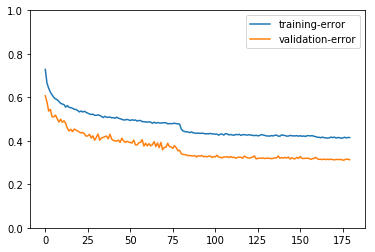

None


In [12]:
print(train_history.plot())

Initialization from Problem 2(b)

In [6]:
from math import sqrt
class MyInit(mx.init.Initializer):
    def _init_weight(self, name, params):
        if (len(params.shape) == 2):
            mx.ndarray.random.normal(loc=0, scale=sqrt(2/params.shape[0]) ,out=params)
        else:
            if (params.shape[0] == 6):
                mx.ndarray.random.normal(loc=0, scale=sqrt(2/(28*28*6)) ,out=params)
            else:
                if (params.shape[0] == 16):
                    mx.ndarray.random.normal(loc=0, scale=sqrt(2/(10*10*16)) ,out=params)
                else:
                    mx.ndarray.random.normal(loc=0, scale=sqrt(2/(8*8*32)) ,out=params)


In [7]:
############################################################
# your code here to define your net according to problem 2 #
net = nn.Sequential()
net.add(
    nn.Conv2D(6,kernel_size=5,strides=1,activation='relu'),
    nn.MaxPool2D(pool_size=2,strides=2), #pool_size???
    nn.Conv2D(16,kernel_size=5,strides=1,activation='relu'),
    nn.MaxPool2D(pool_size=2,strides=2), #pool_size???
    nn.Dense(128,activation='relu'), #nn.Dropout(0.5)
    nn.Dense(84,activation='relu'), #nn.Dropout(0.5)
    nn.Dense(10))


############################################################
# your code here to do initialization using existing API #
# net.initialize(init=init.MSRAPrelu(),ctx=ctx)
net.initialize(MyInit(),ctx=ctx)

Problem c, Add BN layer after each convolution and FC layer

In [5]:
#learning rated changed to be 0.1
net = nn.Sequential()
net.add(
    nn.Conv2D(6,kernel_size=5,strides=1,activation='relu'), nn.BatchNorm(),
    nn.MaxPool2D(pool_size=2,strides=2),  #pool_size???
    nn.Conv2D(16,kernel_size=5,strides=1,activation='relu'), nn.BatchNorm(), 
    nn.MaxPool2D(pool_size=2,strides=2), #pool_size???
    nn.Dense(128,activation='relu'), nn.BatchNorm(), #nn.Dropout(0.5)
    nn.Dense(84,activation='relu'), nn.BatchNorm(), #nn.Dropout(0.5)
    nn.Dense(10))


############################################################
# your code here to do initialization using existing API #
net.initialize(init=init.MSRAPrelu(),ctx=ctx)
# net.initialize(MyInit,ctx=ctx)
# net.initialize(init=init.Normal(0.1),ctx=ctx)

In [9]:
###############################################################
# Training

epochs = 180
lr_decay_count = 0

for epoch in range(epochs):
    tic = time.time()
    train_metric.reset()
    train_loss = 0

    # Learning rate decay
    if epoch == lr_decay_epoch[lr_decay_count]:
        trainer.set_learning_rate(trainer.learning_rate*lr_decay)
        lr_decay_count += 1

    # Loop through each batch of training data
    for i, batch in enumerate(train_data):
        # Extract data and label
        data = gluon.utils.split_and_load(batch[0], ctx_list=ctx, batch_axis=0)
        label = gluon.utils.split_and_load(batch[1], ctx_list=ctx, batch_axis=0)

        # AutoGrad
        with ag.record():
            output = [net(X) for X in data]
            loss = [loss_fn(yhat, y) for yhat, y in zip(output, label)]

        # Backpropagation
        for l in loss:
            l.backward()

        # Optimize
        trainer.step(batch_size,ignore_stale_grad=True)

        # Update metrics
        train_loss += sum([l.sum().asscalar() for l in loss])
        train_metric.update(label, output)

    name, acc = train_metric.get()
    # Evaluate on Validation data
    name, val_acc = test(ctx, val_data)

    # Update history and print metrics
    train_history.update([1-acc, 1-val_acc])
    print('[Epoch %d] train=%f val=%f loss=%f time: %f' %
        (epoch, acc, val_acc, train_loss, time.time()-tic))


# We can plot the metric scores with:

###############################################################
# your code here to plot the training curve and test accuracy #
train_history.plot(save_path='out2.png')
print(train_history.plot())


###############################################################
# your code here to save parameters and visualize the ﬁlters  #
net.save_parameters('net.params')
print(net[0].weight.data())


[Epoch 0] train=0.304507 val=0.425300 loss=94797.420120 time: 4.498891
[Epoch 1] train=0.370873 val=0.455200 loss=86105.953903 time: 5.224936
[Epoch 2] train=0.400341 val=0.496500 loss=82705.220535 time: 5.326877
[Epoch 3] train=0.416386 val=0.509000 loss=80727.006104 time: 4.491915
[Epoch 4] train=0.420833 val=0.527200 loss=79695.775986 time: 4.620241
[Epoch 5] train=0.434575 val=0.528300 loss=78347.366043 time: 4.838556
[Epoch 6] train=0.441747 val=0.524200 loss=77875.618942 time: 5.431433
[Epoch 7] train=0.443149 val=0.550400 loss=77253.941696 time: 5.054038
[Epoch 8] train=0.449058 val=0.526600 loss=76470.988144 time: 4.504523
[Epoch 9] train=0.447276 val=0.533300 loss=76498.355774 time: 6.086639
[Epoch 10] train=0.452865 val=0.566000 loss=75927.172287 time: 5.991343
[Epoch 11] train=0.459095 val=0.564700 loss=75406.910095 time: 5.195843
[Epoch 12] train=0.455429 val=0.564700 loss=75466.543350 time: 5.658615
[Epoch 13] train=0.460136 val=0.557500 loss=75186.269226 time: 4.592912
[E

[Epoch 114] train=0.557151 val=0.687300 loss=62182.370544 time: 4.671180
[Epoch 115] train=0.563782 val=0.677800 loss=61434.213364 time: 5.560514
[Epoch 116] train=0.559375 val=0.671000 loss=61795.208603 time: 5.064659
[Epoch 117] train=0.566106 val=0.679500 loss=61449.489105 time: 4.699009
[Epoch 118] train=0.559956 val=0.657700 loss=61783.177483 time: 5.233604
[Epoch 119] train=0.564403 val=0.679000 loss=61544.543655 time: 4.954102
[Epoch 120] train=0.558834 val=0.682700 loss=61695.648209 time: 4.540101
[Epoch 121] train=0.559575 val=0.682700 loss=62287.142960 time: 4.777719
[Epoch 122] train=0.562019 val=0.680200 loss=61785.223679 time: 4.845449
[Epoch 123] train=0.562260 val=0.680600 loss=61664.896538 time: 4.553586
[Epoch 124] train=0.561979 val=0.680000 loss=61597.595825 time: 5.406445
[Epoch 125] train=0.561579 val=0.675200 loss=61877.659515 time: 5.124212
[Epoch 126] train=0.562500 val=0.678700 loss=61673.975922 time: 4.727118
[Epoch 127] train=0.560697 val=0.678900 loss=61606.

<Figure size 640x480 with 1 Axes>

None

[[[[ 0.32826588  0.3419989  -0.14260693 -0.20803833 -0.04895673]
   [ 0.6813489  -0.4470105  -0.82163817  0.00333026  0.27067736]
   [ 0.19335838 -0.9772385  -0.3395275   0.76504576  0.20918095]
   [-0.26023835 -0.5031097   0.45246205  0.7478764  -0.352996  ]
   [ 0.00474852  0.09768885  0.37320438  0.05576739 -0.4531042 ]]

  [[ 0.27695647  0.16259703 -0.30211058 -0.19717479  0.08366515]
   [ 0.66292596 -0.5679652  -0.89720064  0.1068005   0.5087762 ]
   [ 0.1843432  -1.0772184  -0.41138974  0.84776807  0.38851315]
   [-0.27861732 -0.568593    0.4069627   0.8047005  -0.22429264]
   [-0.10657608  0.02553997  0.352742    0.11767615 -0.30317172]]

  [[ 0.28746518  0.1905743  -0.34291998 -0.32444966 -0.0697959 ]
   [ 0.71545535 -0.4569758  -0.8458556   0.0374663   0.40546173]
   [ 0.19607845 -0.97585016 -0.3788805   0.7612996   0.32372457]
   [-0.2876615  -0.46593627  0.46403724  0.774177   -0.22876056]
   [-0.17235282  0.12135982  0.45268428  0.1575458  -0.30126107]]]


 [[[-0.1059

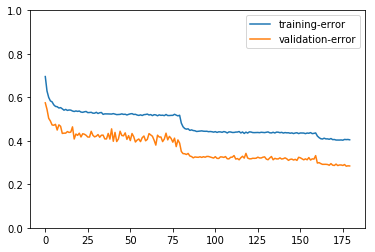

None


In [10]:
print(train_history.plot())

We changed a higher learning rate to be 0.1 for this new model that adds BN layer after each layer. And according to the result, the new model could improve the testing accuracy by 2 percent.

Prob d, try ADAM

In [6]:
def adam(states, hyperparams):
    hp, beta1, beta2, eps = hyperparams, 0.9, 0.999, 1e-6
    l = len(params)
    for i in range(0,l):
        v,s = states[i]
        p = params[i].weight
        v[:] = beta1 * v + (1 - beta1) * p.grad()
        s[:] = beta2 * s + (1 - beta2) * p.grad().square()
        
        v_bias_corr = v / (1 - beta1 ** hp['t'])
        s_bias_corr = s / (1 - beta2 ** hp['t'])

        p.data()[:] -= hp['lr'] * v_bias_corr / (s_bias_corr.sqrt() + eps)
    hp['t'] = hp['t']+1

In [7]:
################################################################
# Optimizer, Loss and Metric

# Learning rate decay factor
lr_decay = 0.1
# Epochs where learning rate decays
lr_decay_epoch = [80, 160, np.inf]

# standard SGD gradient descent
optimizer = 'adam'
# Set parameters
# optimizer_params = {'learning_rate': 0.01, 'wd': 0.0001, 'momentum': 0.9}
optimizer_params = {'learning_rate': 0.001}

# Define our trainer for net
trainer = gluon.Trainer(net.collect_params(), optimizer, optimizer_params)

# loss function.

loss_fn = gluon.loss.SoftmaxCrossEntropyLoss()

In [9]:
###############################################################
# Training

epochs = 180
lr_decay_count = 0

for epoch in range(epochs):
    tic = time.time()
    train_metric.reset()
    train_loss = 0

    # Learning rate decay
    if epoch == lr_decay_epoch[lr_decay_count]:
        trainer.set_learning_rate(trainer.learning_rate*lr_decay)
        lr_decay_count += 1

    # Loop through each batch of training data
    for i, batch in enumerate(train_data):
        # Extract data and label
        data = gluon.utils.split_and_load(batch[0], ctx_list=ctx, batch_axis=0)
        label = gluon.utils.split_and_load(batch[1], ctx_list=ctx, batch_axis=0)

        # AutoGrad
        with ag.record():
            output = [net(X) for X in data]
            loss = [loss_fn(yhat, y) for yhat, y in zip(output, label)]

        # Backpropagation
        for l in loss:
            l.backward()

        # Optimize
        trainer.step(batch_size)

        # Update metrics
        train_loss += sum([l.sum().asscalar() for l in loss])
        train_metric.update(label, output)

    name, acc = train_metric.get()
    # Evaluate on Validation data
    name, val_acc = test(ctx, val_data)

    # Update history and print metrics
    train_history.update([1-acc, 1-val_acc])
    print('[Epoch %d] train=%f val=%f loss=%f time: %f' %
        (epoch, acc, val_acc, train_loss, time.time()-tic))


# We can plot the metric scores with:

###############################################################
# your code here to plot the training curve and test accuracy #
train_history.plot(save_path='out3.png')
print(train_history.plot())


###############################################################
# your code here to save parameters and visualize the ﬁlters  #
net.save_parameters('net.params')
print(net[0].weight.data())


[Epoch 0] train=0.279267 val=0.413500 loss=97868.572693 time: 5.893182
[Epoch 1] train=0.351803 val=0.440800 loss=88098.160568 time: 5.188345
[Epoch 2] train=0.387480 val=0.468600 loss=84332.484558 time: 4.709971
[Epoch 3] train=0.407432 val=0.496900 loss=81935.020416 time: 4.516516
[Epoch 4] train=0.416987 val=0.499400 loss=80450.810287 time: 5.828095
[Epoch 5] train=0.425661 val=0.518100 loss=79320.402267 time: 5.079193
[Epoch 6] train=0.434215 val=0.521700 loss=78301.737991 time: 5.656645
[Epoch 7] train=0.444812 val=0.511200 loss=77230.629822 time: 4.843898
[Epoch 8] train=0.448337 val=0.512700 loss=76460.651688 time: 4.272539
[Epoch 9] train=0.454147 val=0.531600 loss=75574.376877 time: 4.388601
[Epoch 10] train=0.458734 val=0.553100 loss=75284.355530 time: 5.375870
[Epoch 11] train=0.461098 val=0.526700 loss=74826.597412 time: 4.986449
[Epoch 12] train=0.466987 val=0.545900 loss=74264.844238 time: 4.921513
[Epoch 13] train=0.467428 val=0.569500 loss=74121.125244 time: 4.601261
[E

[Epoch 114] train=0.574700 val=0.666200 loss=60057.928375 time: 6.082799
[Epoch 115] train=0.574900 val=0.667200 loss=59990.967979 time: 4.987972
[Epoch 116] train=0.573177 val=0.666200 loss=59920.814674 time: 5.296320
[Epoch 117] train=0.569251 val=0.662600 loss=60304.012093 time: 4.583272
[Epoch 118] train=0.572857 val=0.663200 loss=60254.770782 time: 5.746512
[Epoch 119] train=0.572716 val=0.664400 loss=60130.679672 time: 5.388233
[Epoch 120] train=0.572776 val=0.667000 loss=60121.987930 time: 5.289237
[Epoch 121] train=0.574659 val=0.664500 loss=60029.650452 time: 4.563498
[Epoch 122] train=0.573077 val=0.667400 loss=60196.148743 time: 4.848624
[Epoch 123] train=0.573077 val=0.665400 loss=60011.040077 time: 5.398575
[Epoch 124] train=0.572997 val=0.669000 loss=59817.924332 time: 5.695891
[Epoch 125] train=0.575521 val=0.666500 loss=59690.718460 time: 4.631655
[Epoch 126] train=0.572035 val=0.668800 loss=60363.026657 time: 5.063417
[Epoch 127] train=0.575561 val=0.666600 loss=59851.

<Figure size 640x480 with 1 Axes>

None

[[[[ 1.98755980e-01  4.66397591e-02  1.02732413e-01  4.52624261e-02
     1.43125013e-01]
   [-3.81425880e-02 -1.58610016e-01 -4.50413898e-02  5.94221987e-02
    -1.23736829e-01]
   [-1.18678302e-01 -3.29126860e-03  5.75193018e-02  4.34801169e-02
     1.11078657e-01]
   [-4.99981456e-03 -6.95318878e-02  3.51562314e-02 -1.04560321e-02
     7.69171491e-02]
   [ 2.26715624e-01 -7.32469037e-02 -2.20199004e-01 -1.20066576e-01
    -2.63551287e-02]]

  [[ 3.47680338e-02 -1.62611619e-01 -1.23957358e-02 -8.99359882e-02
    -2.36508369e-01]
   [-7.83514231e-02  5.50910830e-02  3.10380548e-01  2.37153202e-01
     5.58632165e-02]
   [ 2.31528044e-01 -8.01693946e-02  6.42414391e-02  2.20843583e-01
     2.98334837e-01]
   [-3.03304166e-01 -2.51079470e-01  1.29941717e-01 -2.09197719e-02
     4.63623367e-02]
   [ 4.47516814e-02 -2.68477827e-01 -4.16394562e-01 -1.18879350e-02
    -1.33645386e-01]]

  [[ 2.14157254e-03 -1.63325921e-01  1.78467017e-02  5.56950793e-02
    -1.21491626e-01]
   [ 1.3539

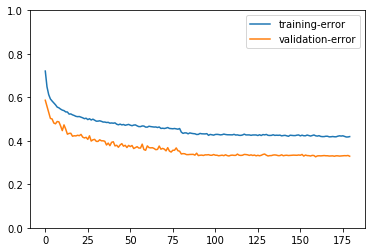

None


In [10]:
print(train_history.plot())